    # Examples Graphs Figures Notebook

In [2]:
figures_dir = "/home/liad/dev/research/figures"

def save_fig(fig, name, end="jpg"):
    full_path = f"{figures_dir}/{name}.{end}"
    fig.savefig(full_path)

In [3]:
import numpy as np
import pandas as pd

from glob import glob
from enum import Enum
from collections import OrderedDict

FREQUENCY = 10
COLUMNS = [0,0.01,0.02,0.04,0.08,0.16,0.32,0.64]
ROWS = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

num_iocs_df = pd.read_csv("/home/liad/dev/research/notebooks/data-vt-v22/attack_num_iocs_vt_v22.csv")

class ConfusionMatrix(Enum):
    RECALL = 0
    PRECISION = 1
    AVG_REWARD = 2

def get_attack_num_iocs(attack_id):
    df = num_iocs_df[num_iocs_df["attack"] == int(attack_id)]
    return int(df["num_iocs"])

def get_attacks_with_num_iocs(niocs_lower_bound=0, niocs_upper_bound=50000):
    df = num_iocs_df[num_iocs_df["num_iocs"] >= niocs_lower_bound]
    df = num_iocs_df[num_iocs_df["num_iocs"] <= niocs_upper_bound]
    return list(df['attack'])

def get_attacks_in_dir(results_dir):
    attack_ids = set()
    for attack_file in glob(f"{results_dir}/cm_*_*.csv*"):
        attack_id = attack_file.split("_")[-3]
        attack_ids.add(attack_id)
    return attack_ids
    
def get_attack_over_time(results_dir, attack_id, iterations, measure, rfp=None, rfn=None, avg_it=2):
    i = 0
    dfs = {}
    attack_num_iocs = -1
    
    # create data frame for each iteration
    while (i <= iterations):
        if rfp == None and rfp == None:
            dfs[i] = pd.DataFrame(columns=COLUMNS, index=ROWS)
        i += FREQUENCY
    
    for attack_file in glob(f"{results_dir}/cm_*_{attack_id}_*_*.csv"):
        attack_file_df = pd.read_csv(attack_file)
        # each attack is a single configuration, i.e. single fp and fn values.
        for r in attack_file_df.iterrows():
            it = r[1]['iteration']
            fp = r[1]['ex_fp']
            fn = r[1]['ex_fn']
            cm_tp, cm_tn, cm_fp, cm_fn = r[1]['cm_tp'],r[1]['cm_tn'],r[1]['cm_fp'],r[1]['cm_fn']
            
            if (it > iterations):
                # sometimes we will ask for less iterations then available
                # thus no need to keep going
                break
                
            if measure == ConfusionMatrix.AVG_REWARD:
                mes = r[1]['avg_rew']
            elif measure == ConfusionMatrix.RECALL:
                if attack_num_iocs < 0:
                    attack_num_iocs = get_attack_num_iocs(attack_id)
                mes = cm_tp / float(attack_num_iocs)
            elif measure == ConfusionMatrix.PRECISION:
                mes = cm_tp / float(cm_tp + cm_fp)
            
            # set measure in corresponding df and corresponding fp and fn
            if rfp == None and rfn == None:
                try:
                    # already there is a value
                    if not pd.isna(dfs[it][fp][fn]):
                        if type(dfs[it][fp][fn]) is list:
                            dfs[it][fp][fn].append(mes)
                            if len(dfs[it][fp][fn]) == avg_it:
                                # put mean instead of accumulated values
                                dfs[it][fp][fn] = np.array(dfs[it][fp][fn]).mean()
                        else:
                            # create a new list of values
                            dfs[it][fp][fn] = [dfs[it][fp][fn], mes]
                            if len(dfs[it][fp][fn]) == avg_it:
                                # put mean instead of accumulated values
                                dfs[it][fp][fn] = np.array(dfs[it][fp][fn]).mean()
                    else:
                        dfs[it][fp][fn] = mes
                except:
                    pass
            elif (rfp and rfn == None):
                if rfp == fp:
                    pass
            elif (rfp == None and rfn):
                if rfn == fn:
                    pass
            # measure requested in specific fn/fp
            elif (fp == rfp and fn == rfn):
                dfs[it] = mes
    print(".", end=" ")
    return dfs

def get_attacks_over_time(results_dir, iterations, measure, avg=True, rfp=None, rfn=None):
    attacks_in_dir = get_attacks_in_dir(results_dir)
    attack_results = {}
    
    for attack in attacks_in_dir:
        print(f"Computing {attack}")
        attack_results[attack] = get_attack_over_time(results_dir, attack_id=attack, iterations=iterations,
                                                     measure=measure, rfp=rfp, rfn=rfn)
    temp = []
    if avg:
        if rfp == None and rfn == None:
            for k,v in attack_results.items():
                v_array = list(v.values())
                v_array = np.array([d.to_numpy() for d in v_array])
                
                if len(temp) == 0:
                    temp = v_array
                else:
                    temp += v_array
            return dict(zip(v.keys(), temp / len(attacks_in_dir)))
        else:
            for k,v in attack_results.items():
                v_array = np.array(list(v.values()))
                if len(temp) == 0:
                    temp = v_array
                else:
                    temp += v_array
            return dict(zip(v.keys(), temp / len(attacks_in_dir)))
    else:
        return attack_results
        

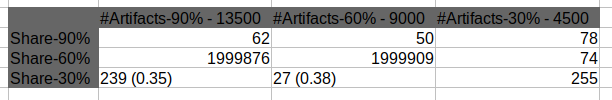

In [2]:
from IPython.display import Image
PATH = "./data-vt-v22/example_attacks.png"
Image(PATH, width=1000, height=1000)

In [4]:
example_without_base = 183866 # saeg01msdf job number which is the base number

In [5]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

def calculate_single_example_attack(attack_id, results_base_num, results_dir, measure, iterations):
    ucb1rnddf = get_attack_over_time(results_dir=f"{results_dir}_{results_base_num + 7}",
                 attack_id=attack_id, iterations=iterations, measure=measure)
    rnddf = get_attack_over_time(results_dir=f"{results_dir}_{results_base_num + 3}",
                     attack_id=attack_id, iterations=iterations, measure=measure)
    saucbmsdf = get_attack_over_time(results_dir=f"{results_dir}_{results_base_num + 4}",
                     attack_id=attack_id, iterations=iterations, measure=measure)
    saeg01msdf = get_attack_over_time(results_dir=f"{results_dir}_{results_base_num}",
                     attack_id=attack_id, iterations=iterations, measure=measure)
    ucb1msdf = get_attack_over_time(results_dir=f"{results_dir}_{results_base_num + 6}",
                     attack_id=attack_id, iterations=iterations, measure=measure)
    rndmsdf = get_attack_over_time(results_dir=f"{results_dir}_{results_base_num + 9}",
                     attack_id=attack_id, iterations=iterations, measure=measure)
    eg01rnddf = get_attack_over_time(results_dir=f"{results_dir}_{results_base_num + 2}",
                     attack_id=attack_id, iterations=iterations, measure=measure)
    saucbrnddf = get_attack_over_time(results_dir=f"{results_dir}_{results_base_num + 5}",
                     attack_id=attack_id, iterations=iterations, measure=measure)
    msdf = get_attack_over_time(results_dir=f"{results_dir}_{results_base_num + 8}",
                     attack_id=attack_id, iterations=iterations, measure=measure)
    eg01msdf = get_attack_over_time(results_dir=f"{results_dir}_{results_base_num + 1}",
                     attack_id=attack_id, iterations=iterations, measure=measure)
    oracledf = get_attack_over_time(results_dir=f"{results_dir}_{results_base_num + 10}",
                     attack_id=attack_id, iterations=iterations, measure=measure)
    print("")
    
    ret_tuple = (ucb1rnddf, rnddf, saucbmsdf, saeg01msdf, 
                 ucb1msdf, rndmsdf, eg01rnddf, saucbrnddf, 
                 msdf, eg01msdf, oracledf)
    
    return ret_tuple

def plot_single_example_attack(fig, results_tuple, xlim, measure="", title="", fp=0, fn=0, yticks=None):
    (ucb1rnddf, rnddf, saucbmsdf, saeg01msdf, 
     ucb1msdf, rndmsdf, eg01rnddf, saucbrnddf, 
     msdf, eg01msdf, oracledf) = results_tuple
    
#   fig = fig.figure(figsize=(12,12))
    fig.set_xlim(0,xlim)
    
    fig.plot(list(oracledf.keys()),
             [v.loc[fn][fp] for k, v in oracledf.items()],
             linewidth=2, label="ORACLE", color="darkred")

    fig.plot(list(saeg01msdf.keys()),
             [v.loc[fn][fp] for k, v in saeg01msdf.items()],
             linewidth=2, label="SAEG01-MS", color="tab:blue")

    fig.plot(list(saucbmsdf.keys()),
             [v.loc[fn][fp] for k, v in saucbmsdf.items()],
             linewidth=2, label="SAUCB-MS", color="tab:green")

    fig.plot(list(eg01msdf.keys()),
             [v.loc[fn][fp] for k, v in eg01msdf.items()],
             linewidth=2, label="EG01-MS", color="tab:orange")

    fig.plot(list(ucb1msdf.keys()),
             [v.loc[fn][fp] for k, v in ucb1msdf.items()],
             linewidth=2, label="UCB1-MS", color="tab:red")

    fig.plot(list(saucbrnddf.keys()),
             [v.loc[fn][fp] for k, v in saucbrnddf.items()],
             linewidth=2, label="SAUCB-Rnd", color="tab:purple")

    fig.plot(list(ucb1rnddf.keys()),
             [v.loc[fn][fp] for k, v in ucb1rnddf.items()],
             linewidth=2, label="UCB1-Rnd", color="tab:pink")

    fig.plot(list(eg01rnddf.keys()),
             [v.loc[fn][fp] for k, v in eg01rnddf.items()],
             linewidth=2, label="EG01-Rnd", color="tab:brown")

#     fig.plot(list(msdf.keys()),
#              [v.loc[fn][fp] for k, v in msdf.items()],
#              linewidth=2, label="MS", color="tab:olive")

#     fig.plot(list(rndmsdf.keys()),
#              [v.loc[fn][fp] for k, v in rndmsdf.items()],
#              linewidth=2, label="Rnd-MS", color="tab:gray")

    fig.plot(list(rnddf.keys()),
             [v.loc[fn][fp] for k, v in rnddf.items()],
             linewidth=2, label="Rnd-Rnd", color="tab:cyan")
    
    fig.set_title(title, fontsize=18)
    fig.set_xlabel("Iteration", fontsize=18)
    fig.set_ylabel(measure, fontsize=18)
    yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0] if yticks is None else yticks
    fig.set_yticks(yticks)
    fig.tick_params(labelsize=16)

    return fig
    

In [6]:
def plot_legend(fig):
    a_patch = mpatches.Patch(label="ORACLE", color="darkred")
    b_patch = mpatches.Patch(label="SAEG01-MS", color="tab:blue")
    c_patch = mpatches.Patch(label="SAUCB-MS", color="tab:green")
    d_patch = mpatches.Patch(label="EG01-MS", color="tab:orange")
    e_patch = mpatches.Patch(label="UCB1-MS", color="tab:red")
    f_patch = mpatches.Patch(label="SAUCB-Rnd", color="tab:purple")
    g_patch = mpatches.Patch(label="UCB1-Rnd", color="tab:pink")
    h_patch = mpatches.Patch(label="EG01-Rnd", color="tab:brown")
#     i_patch = mpatches.Patch(label="MS", color="tab:olive")
#     j_patch = mpatches.Patch(label="Rnd-MS", color="tab:gray")
    k_patch = mpatches.Patch(label="Rnd-Rnd", color="tab:cyan")
    
    fig.legend(loc='upper right', prop={'size': 24}, 
               handles=[a_patch, b_patch, c_patch, d_patch, e_patch,
                       f_patch,g_patch,h_patch,k_patch],
                       bbox_to_anchor=(1.03, 1.15), ncol=5)

In [10]:
iterations=15000
avgrew_62 = calculate_single_example_attack(62, example_without_base, "/home/liad/dev/research/bgucpu/results/2021_4_27/merged",
                               ConfusionMatrix.AVG_REWARD, iterations)
avgrew_50 = calculate_single_example_attack(50, example_without_base, "/home/liad/dev/research/bgucpu/results/2021_4_27/merged",
                               ConfusionMatrix.AVG_REWARD, iterations)
avgrew_78 = calculate_single_example_attack(78, example_without_base, "/home/liad/dev/research/bgucpu/results/2021_4_27/merged",
                               ConfusionMatrix.AVG_REWARD, iterations)
avgrew_1999876 = calculate_single_example_attack(1999876, example_without_base, "/home/liad/dev/research/bgucpu/results/2021_4_27/merged",
                               ConfusionMatrix.AVG_REWARD, iterations)
avgrew_1999909 = calculate_single_example_attack(1999909, example_without_base, "/home/liad/dev/research/bgucpu/results/2021_4_27/merged",
                               ConfusionMatrix.AVG_REWARD, iterations)
avgrew_74 = calculate_single_example_attack(74, example_without_base, "/home/liad/dev/research/bgucpu/results/2021_4_27/merged",
                               ConfusionMatrix.AVG_REWARD, iterations)
avgrew_239 = calculate_single_example_attack(239, example_without_base, "/home/liad/dev/research/bgucpu/results/2021_4_27/merged",
                               ConfusionMatrix.AVG_REWARD, iterations)
avgrew_27 = calculate_single_example_attack(27, example_without_base, "/home/liad/dev/research/bgucpu/results/2021_4_27/merged",
                               ConfusionMatrix.AVG_REWARD, iterations)
avgrew_255 = calculate_single_example_attack(255, example_without_base, "/home/liad/dev/research/bgucpu/results/2021_4_27/merged",
                               ConfusionMatrix.AVG_REWARD, iterations)

. . . 

KeyboardInterrupt: 

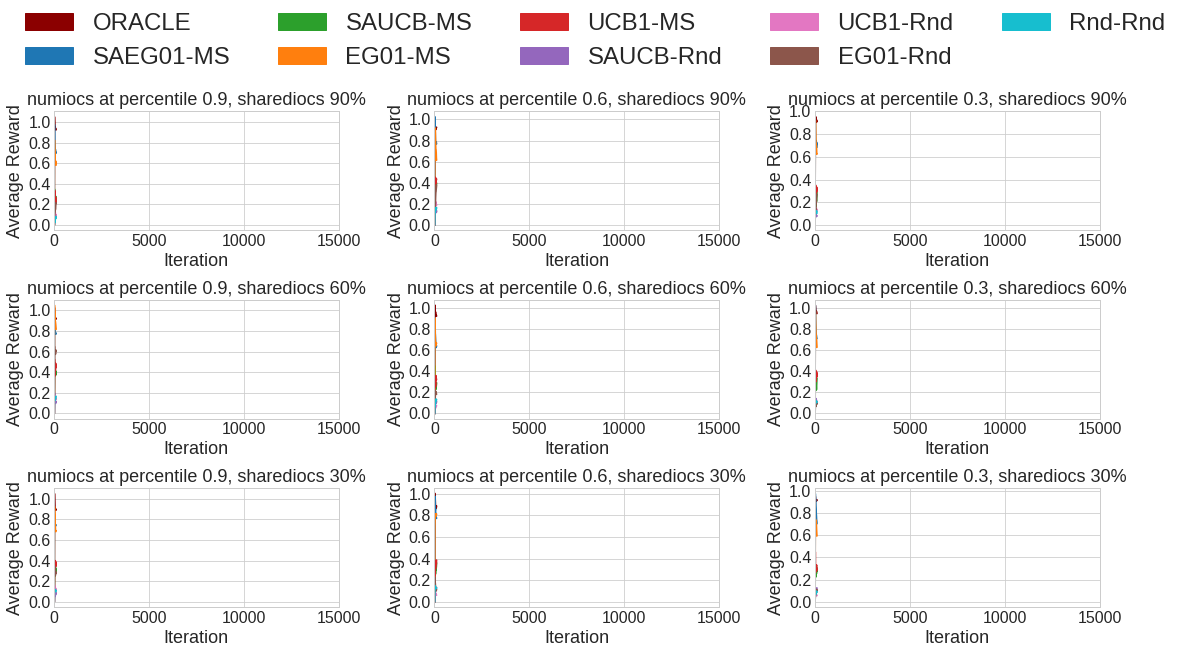

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(3, 3, figsize=(16,8))


f_avgrew_62 = plot_single_example_attack(ax[0][0], avgrew_62, 15000, measure="Average Reward", title="numiocs at percentile 0.9, sharediocs 90%", fp=0.01, fn=0.1)
f_avgrew_50 = plot_single_example_attack(ax[0][1], avgrew_50, 15000, measure="Average Reward", title="numiocs at percentile 0.6, sharediocs 90%", fp=0.01, fn=0.1)
f_avgrew_78 = plot_single_example_attack(ax[0][2], avgrew_78, 15000, measure="Average Reward", title="numiocs at percentile 0.3, sharediocs 90%", fp=0.01, fn=0.1)
f_avgrew_1999876 = plot_single_example_attack(ax[1][0], avgrew_1999876, 15000, measure="Average Reward", title="numiocs at percentile 0.9, sharediocs 60%",fp=0.01, fn=0.1)
f_avgrew_1999909 = plot_single_example_attack(ax[1][1], avgrew_1999909, 15000, measure="Average Reward", title="numiocs at percentile 0.6, sharediocs 60%",fp=0.01, fn=0.1)
f_avgrew_74 = plot_single_example_attack(ax[1][2], avgrew_74, 15000, measure="Average Reward", title="numiocs at percentile 0.3, sharediocs 60%",fp=0.01, fn=0.1)
f_avgrew_239 = plot_single_example_attack(ax[2][0], avgrew_239, 15000, measure="Average Reward", title="numiocs at percentile 0.9, sharediocs 30%",fp=0.01, fn=0.1)
f_avgrew_27 = plot_single_example_attack(ax[2][1], avgrew_27, 15000, measure="Average Reward", title="numiocs at percentile 0.6, sharediocs 30%",fp=0.01, fn=0.1)
f_avgrew_255 = plot_single_example_attack(ax[2][2], avgrew_255, 15000, measure="Average Reward", title="numiocs at percentile 0.3, sharediocs 30%",fp=0.01, fn=0.1)
plot_legend(fig)
# fig.suptitle("Average Reward (Without attack, Pfp=0.01, Pfn=0.1)", fontsize=24)
fig.tight_layout()
save_fig(fig, "example-attacks/average-reward-001-01")

In [17]:
results_dir = "/home/liad/dev/research/bgucpu/results/2021_4_27/merged"

precision_62 = calculate_single_example_attack(62, example_without_base, results_dir,
                               ConfusionMatrix.PRECISION, 15000)
precision_50 = calculate_single_example_attack(50, example_without_base, results_dir,
                               ConfusionMatrix.PRECISION, 15000)
precision_78 = calculate_single_example_attack(78, example_without_base, results_dir,
                               ConfusionMatrix.PRECISION, 15000)
precision_1999876 = calculate_single_example_attack(1999876, example_without_base, results_dir,
                               ConfusionMatrix.PRECISION, 15000)
precision_1999909 = calculate_single_example_attack(1999909, example_without_base, results_dir,
                               ConfusionMatrix.PRECISION, 15000)
precision_74 = calculate_single_example_attack(74, example_without_base, results_dir,
                               ConfusionMatrix.PRECISION, 15000)
precision_239 = calculate_single_example_attack(239, example_without_base, results_dir,
                               ConfusionMatrix.PRECISION, 15000)
precision_27 = calculate_single_example_attack(27, example_without_base, results_dir,
                               ConfusionMatrix.PRECISION, 15000)
precision_255 = calculate_single_example_attack(255, example_without_base, results_dir,
                               ConfusionMatrix.PRECISION, 15000)

/home/liad/miniconda3/envs/jnotebook/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 


Text(0.5, 0.98, 'Precision (Without attack, Pfp=0.01, Pfn=0.1, yticks=yticks)')

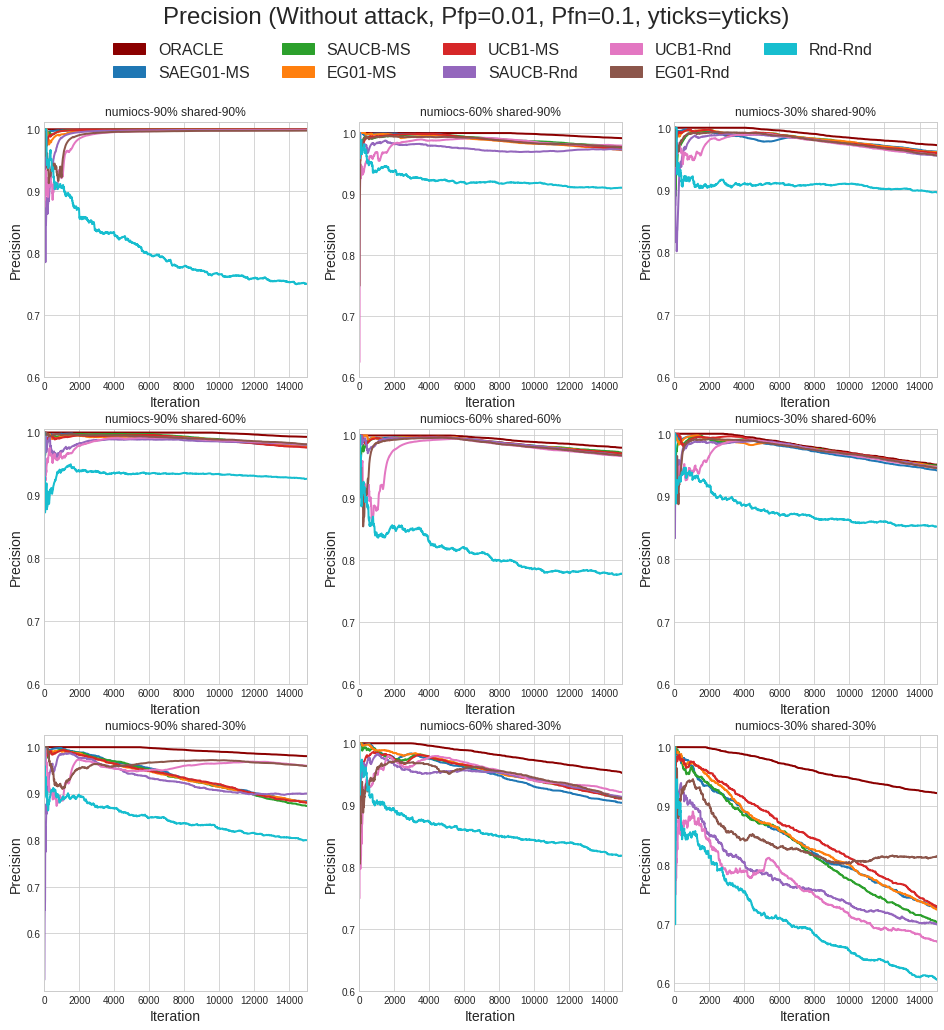

In [102]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(3, 3, figsize=(16,16))
yticks = [0.6, 0.7, 0.8, 0.9, 1.0]

f_precision_62 = plot_single_example_attack(ax[0][0], precision_62, 15000, measure="Precision", title="numiocs-90% shared-90%", fp=0.01, fn=0.1, yticks=yticks)
f_precision_50 = plot_single_example_attack(ax[0][1], precision_50, 15000, measure="Precision", title="numiocs-60% shared-90%", fp=0.01, fn=0.1, yticks=yticks)
f_precision_78 = plot_single_example_attack(ax[0][2], precision_78, 15000, measure="Precision", title="numiocs-30% shared-90%", fp=0.01, fn=0.1, yticks=yticks)
f_precision_1999876 = plot_single_example_attack(ax[1][0], precision_1999876, 15000, measure="Precision", title="numiocs-90% shared-60%",fp=0.01, fn=0.1, yticks=yticks)
f_precision_1999909 = plot_single_example_attack(ax[1][1], precision_1999909, 15000, measure="Precision", title="numiocs-60% shared-60%",fp=0.01, fn=0.1, yticks=yticks)
f_precision_74 = plot_single_example_attack(ax[1][2], precision_74, 15000, measure="Precision", title="numiocs-30% shared-60%",fp=0.01, fn=0.1, yticks=yticks)
f_precision_239 = plot_single_example_attack(ax[2][0], precision_239, 15000, measure="Precision", title="numiocs-90% shared-30%",fp=0.01, fn=0.1, yticks=yticks)
f_precision_27 = plot_single_example_attack(ax[2][1], precision_27, 15000, measure="Precision", title="numiocs-60% shared-30%",fp=0.01, fn=0.1, yticks=yticks)
f_precision_255 = plot_single_example_attack(ax[2][2], precision_255, 15000, measure="Precision", title="numiocs-30% shared-30%",fp=0.01, fn=0.1, yticks=yticks)

plot_legend(fig)
fig.suptitle("Precision (Without attack, Pfp=0.01, Pfn=0.1, yticks=yticks)", fontsize=24)

In [84]:
results_dir = "/home/liad/dev/research/bgucpu/results/2021_4_27/merged"
recall_62 = calculate_single_example_attack(62, example_without_base, results_dir,
                               ConfusionMatrix.RECALL, 15000)
recall_50 = calculate_single_example_attack(50, example_without_base, results_dir,
                               ConfusionMatrix.RECALL, 15000)
recall_78 = calculate_single_example_attack(78, example_without_base, results_dir,
                               ConfusionMatrix.RECALL, 15000)
recall_1999876 = calculate_single_example_attack(1999876, example_without_base, results_dir,
                               ConfusionMatrix.RECALL, 15000)
recall_1999909 = calculate_single_example_attack(1999909, example_without_base, results_dir,
                               ConfusionMatrix.RECALL, 15000)
recall_74 = calculate_single_example_attack(74, example_without_base, results_dir,
                               ConfusionMatrix.RECALL, 15000)
recall_239 = calculate_single_example_attack(239, example_without_base, results_dir,
                               ConfusionMatrix.RECALL, 15000)
recall_27 = calculate_single_example_attack(27, example_without_base, results_dir,
                               ConfusionMatrix.RECALL, 15000)
recall_255 = calculate_single_example_attack(255, example_without_base, results_dir,
                               ConfusionMatrix.RECALL, 15000)

. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 
. . . . . . . . . . . 
. . . 

FileNotFoundError: [Errno 2] File /home/liad/dev/research/bgucpu/results/2021_4_27/merged_183866/cm_EGreedyMultiMostSharedOrder_255_4_47.csv does not exist: '/home/liad/dev/research/bgucpu/results/2021_4_27/merged_183866/cm_EGreedyMultiMostSharedOrder_255_4_47.csv'

In [104]:
recall_255 = calculate_single_example_attack(255, example_without_base, results_dir,
                               ConfusionMatrix.RECALL, 100)

. . . . . . . . . . . 


Text(0.5, 0.98, 'Recall (Without attack, Pfp=0.01, Pfn=0.1)')

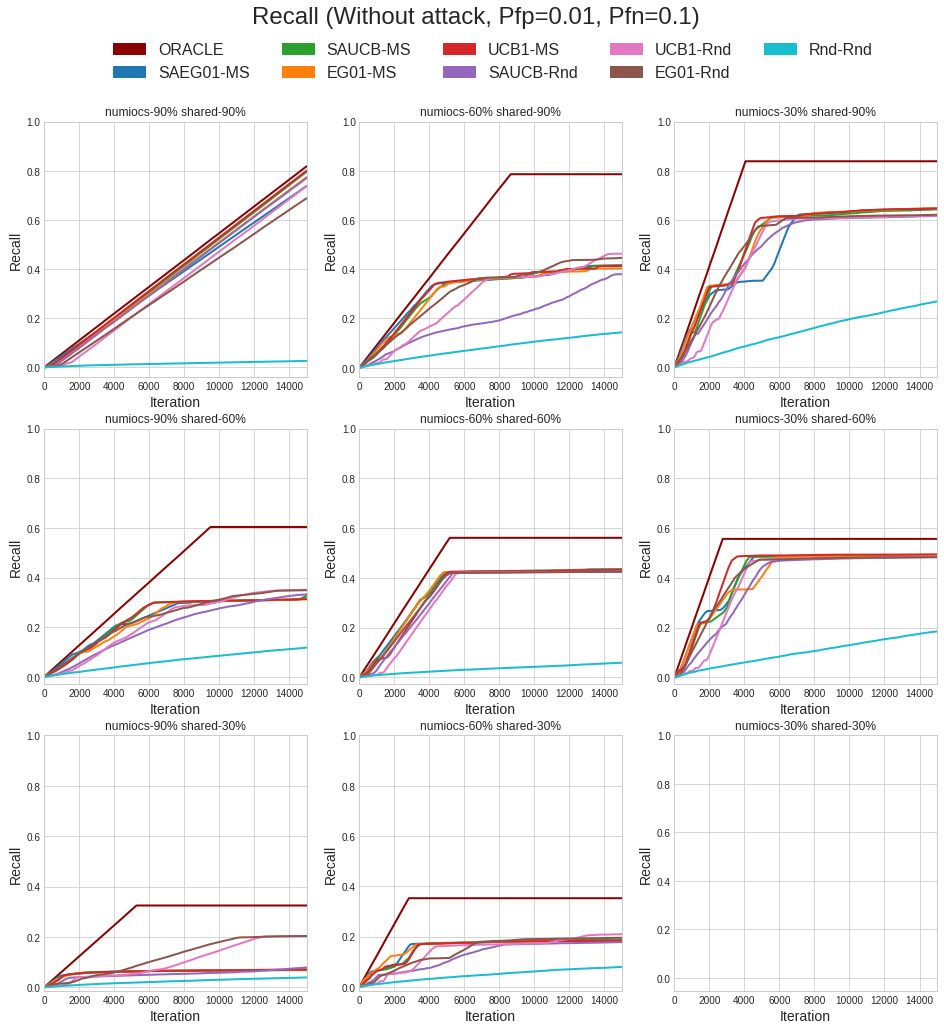

In [96]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(3, 3, figsize=(16,16))

f_recall_62 = plot_single_example_attack(ax[0][0], recall_62, 15000, measure="Recall", title="numiocs-90% shared-90%", fp=0.01, fn=0.1)
f_recall_50 = plot_single_example_attack(ax[0][1], recall_50, 15000, measure="Recall", title="numiocs-60% shared-90%", fp=0.01, fn=0.1)
f_recall_78 = plot_single_example_attack(ax[0][2], recall_78, 15000, measure="Recall", title="numiocs-30% shared-90%", fp=0.01, fn=0.1)
f_recall_1999876 = plot_single_example_attack(ax[1][0], recall_1999876, 15000, measure="Recall", title="numiocs-90% shared-60%",fp=0.01, fn=0.1)
f_recall_1999909 = plot_single_example_attack(ax[1][1], recall_1999909, 15000, measure="Recall", title="numiocs-60% shared-60%",fp=0.01, fn=0.1)
f_recall_74 = plot_single_example_attack(ax[1][2], recall_74, 15000, measure="Recall", title="numiocs-30% shared-60%",fp=0.01, fn=0.1)
f_recall_239 = plot_single_example_attack(ax[2][0], recall_239, 15000, measure="Recall", title="numiocs-90% shared-30%",fp=0.01, fn=0.1)
f_recall_27 = plot_single_example_attack(ax[2][1], recall_27, 15000, measure="Recall", title="numiocs-60% shared-30%",fp=0.01, fn=0.1)
f_recall_255 = plot_single_example_attack(ax[2][2], recall_255, 15000, measure="Recall", title="numiocs-30% shared-30%",fp=0.01, fn=0.1)

plot_legend(fig)
fig.suptitle("Recall (Without attack, Pfp=0.01, Pfn=0.1)", fontsize=24)